In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# CALCULO DE DISTANCIAS Y TIEMPOS DE RECORRIDO

In [ ]:
import pandas as pd
import numpy as np
import math

df = pd.read_csv("/content/drive/MyDrive/TESIS/REPOSITORIO/rutas_alopuno_25k.csv")

def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(dlon/2)**2
    return 2 * math.asin(math.sqrt(a)) * R

def distancia_google_like(dist):
    factor = np.random.uniform(1.35, 1.60)
    return round(dist * factor, 3)

def estimar_tiempo(distancia_km):

    if distancia_km < 1:
        velocidad = np.random.uniform(18, 24)
        min_t, max_t = 3, 7

    elif distancia_km < 3:
        velocidad = np.random.uniform(22, 30)
        min_t, max_t = 6, 12

    elif distancia_km < 5:
        velocidad = np.random.uniform(26, 32)
        min_t, max_t = 10, 15

    elif distancia_km < 8:
        velocidad = np.random.uniform(28, 35)
        min_t, max_t = 12, 18

    elif distancia_km < 12:
        velocidad = np.random.uniform(30, 38)
        min_t, max_t = 16, 22

    else:
        velocidad = np.random.uniform(32, 40)
        min_t, max_t = 20, 30

    tiempo_min = (distancia_km / velocidad) * 60
    tiempo_min *= np.random.uniform(1.00, 1.08)
    tiempo_min = min(max(tiempo_min, min_t), max_t)

    return round(tiempo_min, 2)

def calcular_dist_tiempo(row):
    try:
        lat1, lon1 = map(float, row['Coordenadas Origen'].split(','))
        lat2, lon2 = map(float, row['Coordenadas Destino'].split(','))
    except:
        return pd.Series([np.nan, np.nan])

    dist_hav = haversine(lat1, lon1, lat2, lon2)
    dist_adj = distancia_google_like(dist_hav)
    time_adj = estimar_tiempo(dist_adj)
    return pd.Series([dist_adj, time_adj])

df[['Distancia (km)', 'Tiempo de Viaje (min)']] = df.apply(calcular_dist_tiempo, axis=1)
df["velocidad (kmh)"] = df["Distancia (km)"] / (df["Tiempo de Viaje (min)"] / 60)

df[["Distancia (km)", "Tiempo de Viaje (min)", "velocidad (kmh)"]] = df[["Distancia (km)", "Tiempo de Viaje (min)", "velocidad (kmh)"]].round(2)

cond1 = df["velocidad (kmh)"] <= 70

cond2 = ~(
    (df["velocidad (kmh)"] < 2) &
    (~df["Hora de Salida"].apply(lambda h: 7 <= int(h[:2]) <= 9 or 17 <= int(h[:2]) <= 19))
)

cond3 = ~(
    (df["Distancia (km)"] > 3) &
    (df["Tiempo de Viaje (min)"] < 3)
)

cond4 = ~(
    (df["Distancia (km)"] < 0.3) &
    (df["Tiempo de Viaje (min)"] > 20)
)

cond5 = ~(
    (df["Distancia (km)"] > 4) &
    (df["velocidad (kmh)"] < 10)
)

cond_final = cond1 & cond2 & cond3 & cond4 & cond5
df_limpio = df[cond_final].copy()
df_descartados = df[~cond_final].copy()


In [ ]:
def iqr_filter(col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return (col < lower) | (col > upper)

out_iqr_dist = iqr_filter(df_limpio["Distancia (km)"])
out_iqr_time = iqr_filter(df_limpio["Tiempo de Viaje (min)"])
out_iqr_vel = iqr_filter(df_limpio["velocidad (kmh)"])

outliers_total = out_iqr_dist | out_iqr_time | out_iqr_vel

df_outliers = df_limpio[outliers_total].copy()
df_final = df_limpio[~outliers_total].copy()

count_iqr_dist = out_iqr_dist.sum()
count_iqr_time = out_iqr_time.sum()
count_iqr_vel = out_iqr_vel.sum()

z_dist = ((df_limpio["Distancia (km)"] - df_limpio["Distancia (km)"].mean()) /
          df_limpio["Distancia (km)"].std()).abs() > 3
z_time = ((df_limpio["Tiempo de Viaje (min)"] - df_limpio["Tiempo de Viaje (min)"].mean()) /
          df_limpio["Tiempo de Viaje (min)"].std()).abs() > 3
z_vel = ((df_limpio["velocidad (kmh)"] - df_limpio["velocidad (kmh)"].mean()) /
         df_limpio["velocidad (kmh)"].std()).abs() > 3

count_z_dist = z_dist.sum()
count_z_time = z_time.sum()
count_z_vel = z_vel.sum()

p_dist = (df_limpio["Distancia (km)"] < df_limpio["Distancia (km)"].quantile(0.01)) | \
         (df_limpio["Distancia (km)"] > df_limpio["Distancia (km)"].quantile(0.99))
p_time = (df_limpio["Tiempo de Viaje (min)"] < df_limpio["Tiempo de Viaje (min)"].quantile(0.01)) | \
         (df_limpio["Tiempo de Viaje (min)"] > df_limpio["Tiempo de Viaje (min)"].quantile(0.99))
p_vel = (df_limpio["velocidad (kmh)"] < df_limpio["velocidad (kmh)"].quantile(0.01)) | \
        (df_limpio["velocidad (kmh)"] > df_limpio["velocidad (kmh)"].quantile(0.99))

count_p_dist = p_dist.sum()
count_p_time = p_time.sum()
count_p_vel = p_vel.sum()

total_outliers_unicos = df_outliers.shape[0]

print("\n--- DETECCIÓN DE OUTLIERS ---\n")
print(f"Outliers IQR en Distancia (km): {count_iqr_dist}")
print(f"Outliers IQR en Tiempo de Viaje (min): {count_iqr_time}")
print(f"Outliers IQR en velocidad (kmh): {count_iqr_vel}")

print(f"\nOutliers Z-score en Distancia (km): {count_z_dist}")
print(f"Outliers Z-score en Tiempo de Viaje (min): {count_z_time}")
print(f"Outliers Z-score en velocidad (kmh): {count_z_vel}")

print(f"\nOutliers Percentiles en Distancia (km): {count_p_dist}")
print(f"Outliers Percentiles en Tiempo de Viaje (min): {count_p_time}")
print(f"Outliers Percentiles en velocidad (kmh): {count_p_vel}")

df_descartados = pd.concat([df_descartados, df_outliers], ignore_index=True)
df_final.to_csv("/content/drive/MyDrive/TESIS/REPOSITORIO/rutas_limpias_final.csv", index=False)
df_descartados.to_csv("/content/drive/MyDrive/TESIS/REPOSITORIO/rutas_descartados_total.csv", index=False)

total_descartados = len(df_descartados)

print("\n--- RESUMEN DE ELIMINADOS ---")
print("Registros originales:", len(df))
print("Registros finales:", len(df_final))
print("Total de registros descartados:", total_descartados)
print("\nEstadísticas del dataset final:")
print(df_final[['Distancia (km)', 'Tiempo de Viaje (min)', 'velocidad (kmh)']].describe())



--- DETECCIÓN DE OUTLIERS ---

Outliers IQR en Distancia (km): 269
Outliers IQR en Tiempo de Viaje (min): 275
Outliers IQR en velocidad (kmh): 0

Outliers Z-score en Distancia (km): 123
Outliers Z-score en Tiempo de Viaje (min): 59
Outliers Z-score en velocidad (kmh): 0

Outliers Percentiles en Distancia (km): 475
Outliers Percentiles en Tiempo de Viaje (min): 250
Outliers Percentiles en velocidad (kmh): 498

--- RESUMEN DE ELIMINADOS ---
Registros originales: 25000
Registros finales: 24581
Total de registros descartados: 419

Estadísticas del dataset final:
       Distancia (km)  Tiempo de Viaje (min)  velocidad (kmh)
count    24581.000000           24581.000000     24581.000000
mean         3.504714               8.621533        21.368734
std          2.610871               4.251605         7.329818
min          0.070000               3.000000         1.360000
25%          1.400000               6.000000        15.830000
50%          2.780000               6.790000        21.790000


# REPORTE ESTADÍSTICO

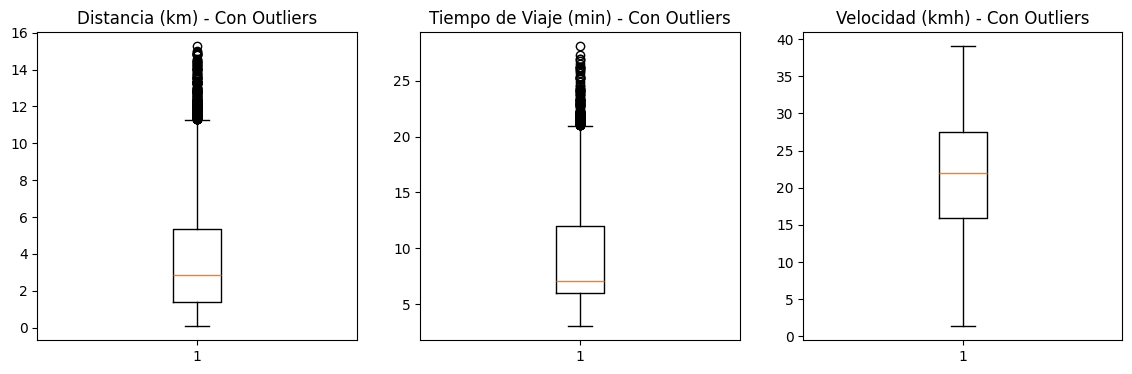

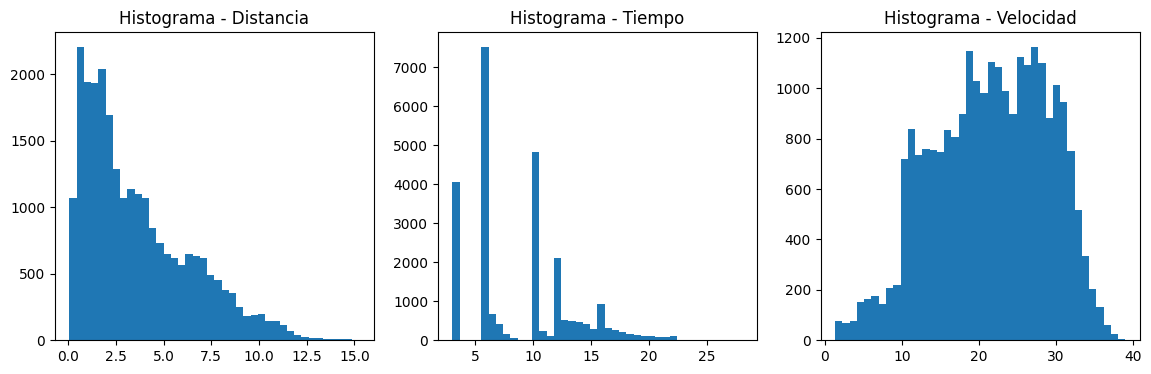

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.boxplot(df_limpio["Distancia (km)"])
plt.title("Distancia (km) - Con Outliers")

plt.subplot(1,3,2)
plt.boxplot(df_limpio["Tiempo de Viaje (min)"])
plt.title("Tiempo de Viaje (min) - Con Outliers")

plt.subplot(1,3,3)
plt.boxplot(df_limpio["velocidad (kmh)"])
plt.title("Velocidad (kmh) - Con Outliers")

plt.show()

plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.hist(df_limpio["Distancia (km)"], bins=40)
plt.title("Histograma - Distancia")

plt.subplot(1,3,2)
plt.hist(df_limpio["Tiempo de Viaje (min)"], bins=40)
plt.title("Histograma - Tiempo")

plt.subplot(1,3,3)
plt.hist(df_limpio["velocidad (kmh)"], bins=40)
plt.title("Histograma - Velocidad")

plt.show()


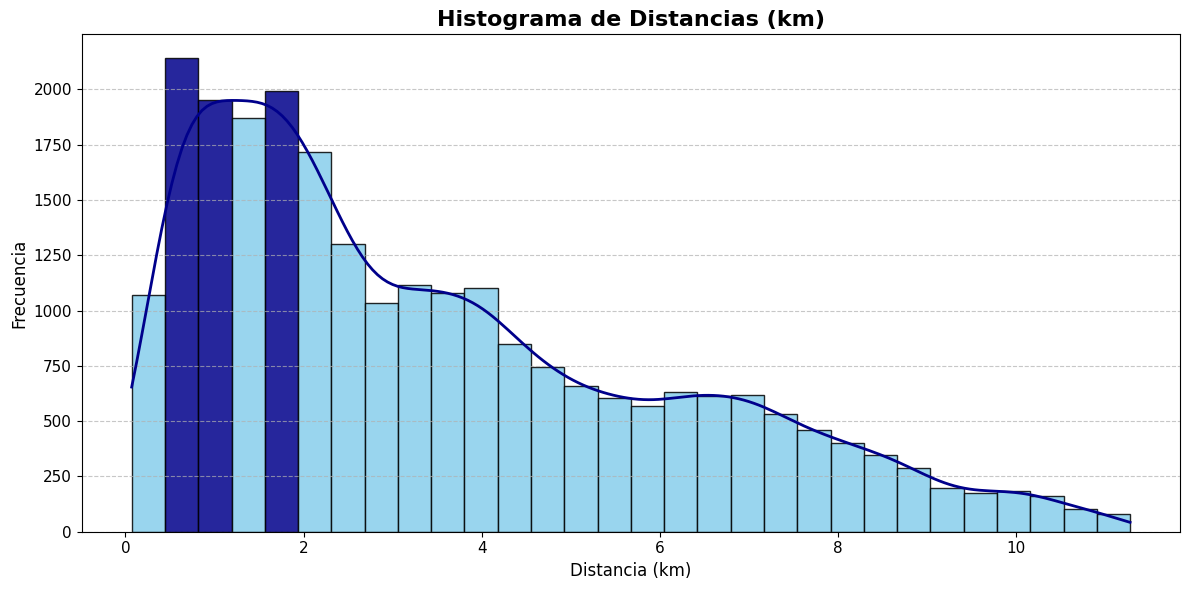

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde

df_final = pd.read_csv("/content/drive/MyDrive/TESIS/REPOSITORIO/rutas_limpias_final.csv")

frecuencias, bins = np.histogram(df_final["Distancia (km)"], bins=30)
centros = (bins[:-1] + bins[1:]) / 2

colores = ['skyblue'] * len(frecuencias)
top3_indices = frecuencias.argsort()[-3:]
for i in top3_indices:
    colores[i] = 'darkblue'

plt.figure(figsize=(12,6))
plt.bar(centros, frecuencias, width=(bins[1]-bins[0]), color=colores, edgecolor='black', alpha=0.85)

kde = gaussian_kde(df_final["Distancia (km)"])
x_kde = np.linspace(df_final["Distancia (km)"].min(), df_final["Distancia (km)"].max(), 200)
plt.plot(x_kde, kde(x_kde)*len(df_final)*(bins[1]-bins[0]), color='darkblue', linewidth=2)  # escalar KDE a histograma

plt.title('Histograma de Distancias (km)', fontsize=16, fontweight='bold')
plt.xlabel('Distancia (km)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


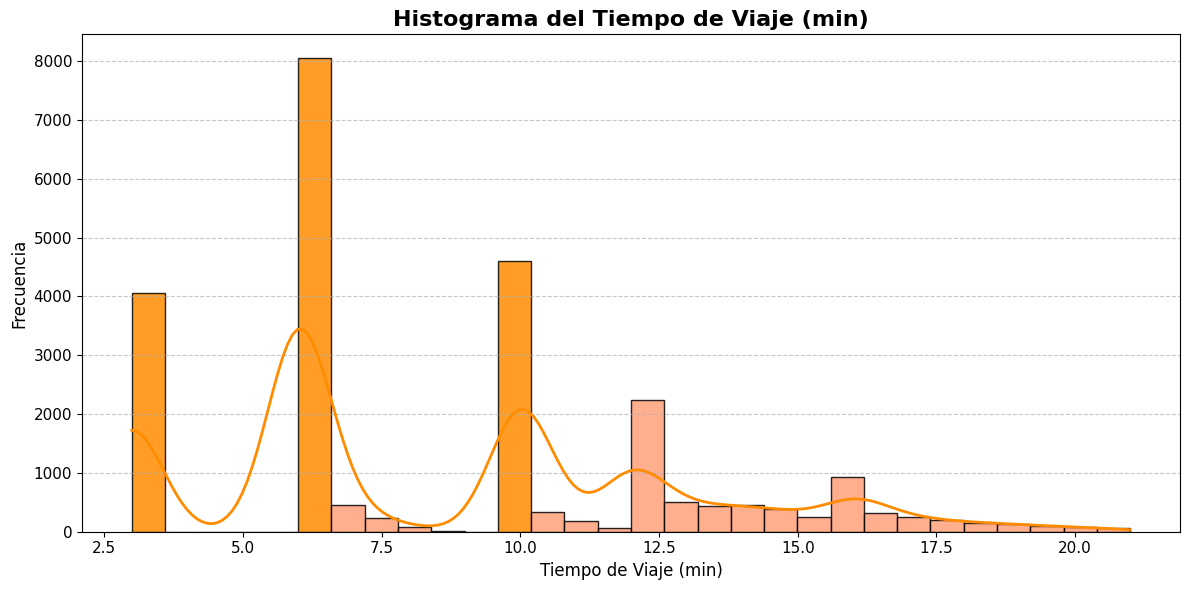

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

frecuencias, bins = np.histogram(df_final["Tiempo de Viaje (min)"], bins=30)
centros = (bins[:-1] + bins[1:]) / 2

colores = ['lightsalmon'] * len(frecuencias)
top3_indices = frecuencias.argsort()[-3:]
for i in top3_indices:
    colores[i] = 'darkorange'

plt.figure(figsize=(12,6))
plt.bar(centros, frecuencias, width=(bins[1]-bins[0]), color=colores, edgecolor='black', alpha=0.85)

kde = gaussian_kde(df_final["Tiempo de Viaje (min)"])
x_kde = np.linspace(df_final["Tiempo de Viaje (min)"].min(), df_final["Tiempo de Viaje (min)"].max(), 200)
plt.plot(x_kde, kde(x_kde)*len(df_final)*(bins[1]-bins[0]), color='darkorange', linewidth=2)
plt.title('Histograma del Tiempo de Viaje (min)', fontsize=16, fontweight='bold')
plt.xlabel('Tiempo de Viaje (min)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


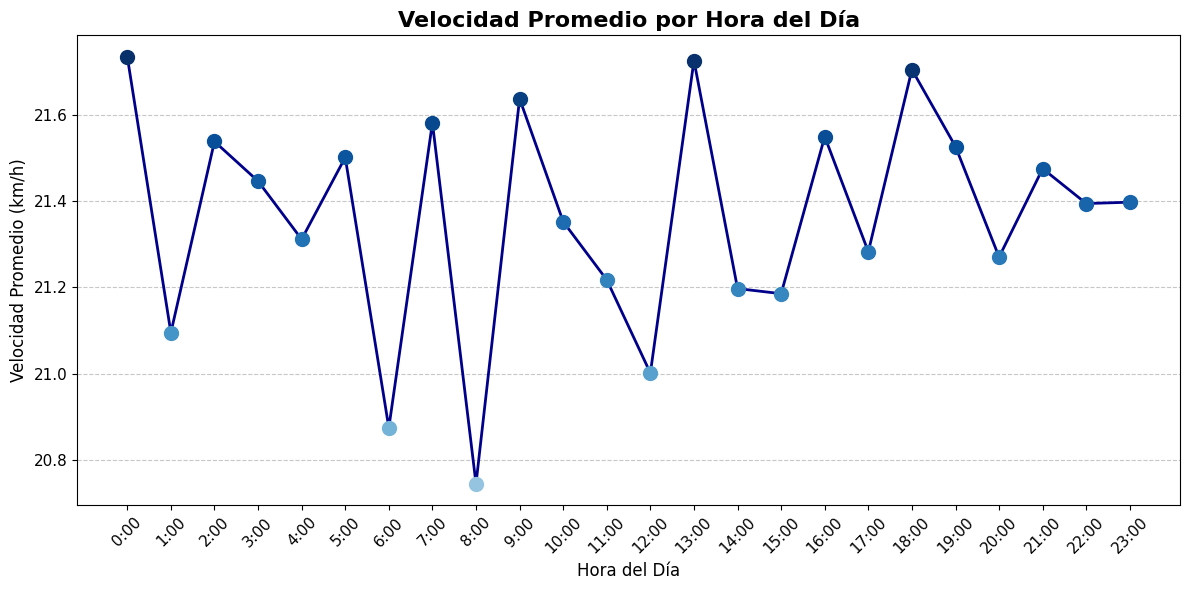

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
horas = df_final["Hora de Salida"].astype(str).str[:2].astype(int)
vel_por_hora = df_final.groupby(horas)["velocidad (kmh)"].mean()
norm = (vel_por_hora - vel_por_hora.min()) / (vel_por_hora.max() - vel_por_hora.min())
colores = [plt.cm.Blues(0.4 + 0.6*v) for v in norm]

plt.figure(figsize=(12,6))
plt.plot(vel_por_hora.index, vel_por_hora.values, color='darkblue', linewidth=2, marker='o', markersize=8)

for x, y, c in zip(vel_por_hora.index, vel_por_hora.values, colores):
    plt.plot(x, y, marker='o', markersize=10, color=c)

plt.title("Velocidad Promedio por Hora del Día", fontsize=16, fontweight='bold')
plt.xlabel("Hora del Día", fontsize=12)
plt.ylabel("Velocidad Promedio (km/h)", fontsize=12)
plt.xticks(vel_por_hora.index, [f"{h}:00" for h in vel_por_hora.index], rotation=45, fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# APLICACION DE ALGORITMOS

In [ ]:
df_final['Nodo_Origen'] = df_final['Coordenadas Origen'].str.strip()
df_final['Nodo_Destino'] = df_final['Coordenadas Destino'].str.strip()

nodos = pd.Index(pd.concat([df_final['Nodo_Origen'], df_final['Nodo_Destino']]).unique(), name="Nodo")
coord_dict = { nodo: tuple(map(float, nodo.split(','))) for nodo in nodos }
n = len(nodos)

matriz_distancias = np.zeros((n, n))
matriz_tiempos = np.zeros((n, n))

for i, nodo_i in enumerate(nodos):
    lat1, lon1 = coord_dict[nodo_i]
    for j, nodo_j in enumerate(nodos):
        if i == j:
            matriz_distancias[i, j] = 0
            matriz_tiempos[i, j] = 0
        else:
            df_ij = df_final[(df_final["Nodo_Origen"]==nodo_i) & (df_final["Nodo_Destino"]==nodo_j)]
            if len(df_ij) > 0:
                matriz_distancias[i, j] = df_ij["Distancia (km)"].mean()
                matriz_tiempos[i, j] = df_ij["Tiempo de Viaje (min)"].mean()
            else:
                lat2, lon2 = coord_dict[nodo_j]
                d = haversine(lat1, lon1, lat2, lon2)
                matriz_distancias[i, j] = distancia_google_like(d)
                matriz_tiempos[i, j] = estimar_tiempo(matriz_distancias[i, j])

dist_norm = matriz_distancias / matriz_distancias.max()
tiempo_norm = matriz_tiempos / matriz_tiempos.max()

peso_dist = 0.6
peso_tiempo = 0.4
matriz_hibrida = (peso_dist * dist_norm) + (peso_tiempo * tiempo_norm)

coord_to_name = {}
for _, row in df_final[['Lugar de Origen', 'Coordenadas Origen']].drop_duplicates().iterrows():
    coord_to_name[row['Coordenadas Origen']] = row['Lugar de Origen']
for _, row in df_final[['Lugar de Destino', 'Coordenadas Destino']].drop_duplicates().iterrows():
    coord_to_name[row['Coordenadas Destino']] = row['Lugar de Destino']

labels_nombres = [coord_to_name.get(c, c) for c in nodos]

In [ ]:
parametros = {
    "ACO": {
        "explorador": {"hormigas": 55, "iters": 260, "evap": 0.3, "alfa": 1,   "beta": 2},
        "explotador": {"hormigas": 30, "iters": 180, "evap": 0.65, "alfa": 2,   "beta": 5},
        "balanceado": {"hormigas": 40, "iters": 220, "evap": 0.5, "alfa": 1.5, "beta": 3}
    },
    "TS": {
        "explorador": {"tabu": 450, "iters": 1400, "vecinos": 1300},
        "explotador": {"tabu": 160, "iters": 700,  "vecinos": 700},
        "balanceado": {"tabu": 300, "iters": 1000, "vecinos": 1000}
    },
    "GA": {
        "explorador": {"gens": 500, "pob": 300, "mut": 0.15},
        "explotador": {"gens": 260, "pob": 160, "mut": 0.07},
        "balanceado": {"gens": 380, "pob": 230, "mut": 0.10}
    }
}


In [ ]:
import numpy as np
import time
def algoritmo_aco(matriz, matriz_tiempos,
                  num_hormigas=40, num_iteraciones=220,
                  evaporacion=0.5, alfa=1.5, beta=3):

    num_lugares = matriz.shape[0]
    t0 = time.time()

    valor_inicial = 1 / (num_lugares * matriz.mean())
    feromonas = np.ones((num_lugares, num_lugares)) * valor_inicial

    def seleccionar(nodo_actual, visitados):
        atractivos = np.zeros(num_lugares)
        for j in range(num_lugares):
            if j not in visitados and matriz[nodo_actual][j] > 0:
                distancia_ajustada = max(0.5, matriz[nodo_actual][j])
                tau = feromonas[nodo_actual][j] ** alfa
                eta = (1 / distancia_ajustada) ** beta
                atractivos[j] = tau * eta
        total = atractivos.sum()
        if total == 0:
            return np.random.choice([j for j in range(num_lugares) if j not in visitados])
        prob = atractivos / total
        return np.random.choice(range(num_lugares), p=prob)

    mejor_ruta = None
    mejor_distancia = float("inf")

    for _ in range(num_iteraciones):
        for _ in range(num_hormigas):
            nodo_actual = np.random.randint(0, num_lugares)
            ruta = [nodo_actual]
            distancia_total = 0
            while len(ruta) < num_lugares:
                sig = seleccionar(nodo_actual, ruta)
                distancia_total += max(0.5, matriz_distancias[nodo_actual][sig])
                ruta.append(sig)
                nodo_actual = sig
            deposito = 1 / distancia_total
            for i in range(len(ruta) - 1):
                feromonas[ruta[i]][ruta[i + 1]] += deposito
            feromonas *= (1 - evaporacion)
            if distancia_total < mejor_distancia:
                mejor_distancia = distancia_total
                mejor_ruta = ruta

    segmentos_dist = [max(0.5, matriz_distancias[mejor_ruta[i]][mejor_ruta[i + 1]])
                      for i in range(len(mejor_ruta) - 1)]
    segmentos_tiempo = [matriz_tiempos[mejor_ruta[i]][mejor_ruta[i + 1]]
                        for i in range(len(mejor_ruta) - 1)]

    dist_real_promedio = round(df_final["Distancia (km)"].mean(), 2)
    tiempo_real_promedio = round(df_final["Tiempo de Viaje (min)"].mean(), 2)

    distancia_promedio_opt = round(np.mean(segmentos_dist), 2)
    tiempo_promedio_opt = round(np.mean(segmentos_tiempo), 2)

    desviacion_dist = round(np.std(segmentos_dist), 2)
    desviacion_tiempo = round(np.std(segmentos_tiempo), 2)

    robustez_dist = round(distancia_promedio_opt / desviacion_dist, 4) if desviacion_dist > 0 else float("inf")
    robustez_tiempo = round(tiempo_promedio_opt / desviacion_tiempo, 4) if desviacion_tiempo > 0 else float("inf")

    mejora_dist = round(((dist_real_promedio - distancia_promedio_opt) /
                         dist_real_promedio) * 100, 2)

    mejora_tiempo = round(((tiempo_real_promedio - tiempo_promedio_opt) /
                           tiempo_real_promedio) * 100, 2)

    tiempo_ejecucion = round(time.time() - t0, 2)

    return {
        "Distancia Promedio Real (km)": dist_real_promedio,
        "Distancia Promedio Optimizada (km)": distancia_promedio_opt,
        "Mejora Porcentual Distancia (%)": mejora_dist,
        "Tiempo Promedio Real (min)": tiempo_real_promedio,
        "Tiempo Promedio Optimizado (min)": tiempo_promedio_opt,
        "Mejora Porcentual Tiempo (%)": mejora_tiempo,
        "Desviación Estándar Distancia Opt (km)": desviacion_dist,
        "Desviación Estándar Tiempo Opt (min)": desviacion_tiempo,
        "Robustez Distancia (R)": robustez_dist,
        "Robustez Tiempo (R)": robustez_tiempo,
        "Tiempo de Ejecución (s)": tiempo_ejecucion,
        "Ruta Óptima": mejor_ruta
    }


In [ ]:

modo = "balanceado"
config = parametros["ACO"][modo]

resultados_aco = algoritmo_aco(
    matriz_hibrida,
    matriz_tiempos,
    num_hormigas=config["hormigas"],
    num_iteraciones=config["iters"],
    evaporacion=config["evap"],
    alfa=config["alfa"],
    beta=config["beta"]
)

print("\n=== Resultados ACO ===")
for k, v in resultados_aco.items():
    if k == "Ruta Óptima":
        ruta_nombres = [labels_nombres[i] for i in v]
        print(f"{k}: {ruta_nombres}")
    else:
        print(f"{k}: {v}")


=== Resultados ACO ===
Distancia Promedio Real (km): 3.5
Distancia Promedio Optimizada (km): 3.15
Mejora Porcentual Distancia (%): 10.0
Tiempo Promedio Real (min): 8.62
Tiempo Promedio Optimizado (min): 8.02
Mejora Porcentual Tiempo (%): 6.96
Desviación Estándar Distancia Opt (km): 2.44
Desviación Estándar Tiempo Opt (min): 3.99
Robustez Distancia (R): 1.291
Robustez Tiempo (R): 2.01
Tiempo de Ejecución (s): 72.06
Ruta Óptima: ['Senati Puno', 'Colegio María Auxiliadora Puno', 'Salcedo Puno', 'Colegio Don Bosco Puno', 'Polideportivo Chanu Chanu Puno', 'Urbanización Salcedo Puno', 'Parque del Niño Puno', 'Cementerio Laykakota Puno', 'Colegio Glorioso San Carlos Puno', 'Colegio Adventista Puno', 'Parque Mariátegui Puno', 'Mirador Puma Uta Puno', 'Hotel Libertador Lago Titicaca Puno', 'Parque San Román Puno', 'Urbanización Bellavista Puno', 'Ministerio de Cultura Puno', 'Hospital Regional Manuel Núñez Butrón', 'Parque Pino Puno', 'Avenida Floral Puno', 'Urbanización Alto Puno', 'Complejo 

In [ ]:
def busqueda_tabu(matriz, matriz_tiempos,
                  tamaño_tabu=300, num_iteraciones=1000,
                  num_vecinos=1000):

    num_lugares = matriz.shape[0]
    t0 = time.time()

    mejor_ruta = np.random.permutation(num_lugares).tolist()

    def calcular_costo(ruta):

        return sum(max(0.5, matriz[ruta[i]][ruta[i + 1]]) for i in range(len(ruta) - 1))

    mejor_costo = calcular_costo(mejor_ruta)
    ruta_actual = mejor_ruta.copy()
    costo_actual = mejor_costo
    lista_tabu = []

    for _ in range(num_iteraciones):
        mejores_vecinos = []

        for _ in range(num_vecinos):
            a, b = np.random.choice(num_lugares, 2, replace=False)
            vecino = ruta_actual.copy()
            vecino[a], vecino[b] = vecino[b], vecino[a]
            movimiento = (a, b)

            if movimiento not in lista_tabu:
                costo_vecino = calcular_costo(vecino)
                mejores_vecinos.append((vecino, costo_vecino, movimiento))

        if not mejores_vecinos:
            continue

        vecino, costo_vecino, movimiento = min(mejores_vecinos, key=lambda x: x[1])
        ruta_actual = vecino
        costo_actual = costo_vecino

        lista_tabu.append(movimiento)
        if len(lista_tabu) > tamaño_tabu:
            lista_tabu.pop(0)

        if costo_actual < mejor_costo:
            mejor_costo = costo_actual
            mejor_ruta = ruta_actual.copy()

    segmentos_dist = [max(0.5, matriz_distancias[mejor_ruta[i]][mejor_ruta[i + 1]])
                      for i in range(len(mejor_ruta) - 1)]
    segmentos_tiempo = [matriz_tiempos[mejor_ruta[i]][mejor_ruta[i + 1]]
                        for i in range(len(mejor_ruta) - 1)]

    dist_real_promedio = round(df_final["Distancia (km)"].mean(), 2)
    tiempo_real_promedio = round(df_final["Tiempo de Viaje (min)"].mean(), 2)

    distancia_promedio_opt = round(np.mean(segmentos_dist), 2)
    tiempo_promedio_opt = round(np.mean(segmentos_tiempo), 2)

    desviacion_dist = round(np.std(segmentos_dist), 2)
    desviacion_tiempo = round(np.std(segmentos_tiempo), 2)

    robustez_dist = round(distancia_promedio_opt / desviacion_dist, 4) if desviacion_dist > 0 else float("inf")
    robustez_tiempo = round(tiempo_promedio_opt / desviacion_tiempo, 4) if desviacion_tiempo > 0 else float("inf")

    mejora_dist = round(((dist_real_promedio - distancia_promedio_opt) /
                         dist_real_promedio) * 100, 2)

    mejora_tiempo = round(((tiempo_real_promedio - tiempo_promedio_opt) /
                           tiempo_real_promedio) * 100, 2)

    tiempo_ejecucion = round(time.time() - t0, 2)

    return {
        "Distancia Promedio Real (km)": dist_real_promedio,
        "Distancia Promedio Optimizada (km)": distancia_promedio_opt,
        "Mejora Porcentual Distancia (%)": mejora_dist,
        "Tiempo Promedio Real (min)": tiempo_real_promedio,
        "Tiempo Promedio Optimizado (min)": tiempo_promedio_opt,
        "Mejora Porcentual Tiempo (%)": mejora_tiempo,
        "Desviación Estándar Distancia Opt (km)": desviacion_dist,
        "Desviación Estándar Tiempo Opt (min)": desviacion_tiempo,
        "Robustez Distancia (R)": robustez_dist,
        "Robustez Tiempo (R)": robustez_tiempo,
        "Tiempo de Ejecución (s)": tiempo_ejecucion,
        "Ruta Óptima": mejor_ruta
    }


In [ ]:
modo = "balanceado"
config_ts = parametros["TS"][modo]

resultados_ts = busqueda_tabu(
    matriz_hibrida,
    matriz_tiempos,
    tamaño_tabu=config_ts["tabu"],
    num_iteraciones=config_ts["iters"],
    num_vecinos=config_ts["vecinos"]
)

print("\n=== Resultados TS ===")
for k, v in resultados_ts.items():
    if k == "Ruta Óptima":
        ruta_nombres = [labels_nombres[i] for i in v]
        print(f"{k}: {ruta_nombres}")
    else:
        print(f"{k}: {v}")


=== Resultados TS ===
Distancia Promedio Real (km): 3.5
Distancia Promedio Optimizada (km): 2.97
Mejora Porcentual Distancia (%): 15.14
Tiempo Promedio Real (min): 8.62
Tiempo Promedio Optimizado (min): 7.94
Mejora Porcentual Tiempo (%): 7.89
Desviación Estándar Distancia Opt (km): 2.0
Desviación Estándar Tiempo Opt (min): 3.29
Robustez Distancia (R): 1.485
Robustez Tiempo (R): 2.4134
Tiempo de Ejecución (s): 64.49
Ruta Óptima: ['Urbanización Huajsapata Puno', 'Hotel Libertador Lago Titicaca Puno', 'Mercado Bellavista Puno', 'Jr. Lima Puno', 'Avenida Floral Puno', 'Hotel Sonesta Posadas del Inca Puno', 'Mercado Unión y Dignidad Puno', 'Avenida La Torre Puno', 'Universidad Andina Néstor Cáceres Velásquez Puno', 'Polideportivo Chanu Chanu Puno', 'Senati Puno', 'Hospital Regional Manuel Núñez Butrón', 'Plaza Vea Puno', 'Urbanización Alto Puno', 'Instituto Americano de Arte Puno', 'Gran Unidad Escolar San Carlos Puno', 'Av. Costanera Puno', 'Jr. Tarapacá Puno', 'Parque San Román Puno', 'H

In [ ]:
def algoritmo_genetico(matriz_opt, matriz_tiempos,
                       generaciones=380, tamaño_poblacion=230,
                       prob_mutacion=0.10):

    num_lugares = matriz_opt.shape[0]
    t0 = time.time()

    def costo(ruta):
        segmentos_dist = [matriz_distancias[ruta[i]][ruta[i+1]] for i in range(len(ruta)-1)]
        segmentos_tiempo = [matriz_tiempos[ruta[i]][ruta[i+1]] for i in range(len(ruta)-1)]
        suma_dist = sum(segmentos_dist)
        suma_tiempo = sum(segmentos_tiempo)
        promedio_dist_segmento = df_final["Distancia (km)"].mean()
        promedio_tiempo_segmento = df_final["Tiempo de Viaje (min)"].mean()
        promedio_dist_esperada = promedio_dist_segmento * len(segmentos_dist) * 0.85
        promedio_tiempo_esperada = promedio_tiempo_segmento * len(segmentos_tiempo) * 0.85
        penalizacion = 0
        if suma_dist < promedio_dist_esperada:
            penalizacion += (promedio_dist_esperada - suma_dist) * 4
        if suma_tiempo < promedio_tiempo_esperada:
            penalizacion += (promedio_tiempo_esperada - suma_tiempo) * 3
        peso_dist = 0.6
        peso_tiempo = 0.4
        return peso_dist * suma_dist + peso_tiempo * suma_tiempo + penalizacion

    def crear_ruta():
        return np.random.permutation(num_lugares).tolist()

    def crear_poblacion():
        return [crear_ruta() for _ in range(tamaño_poblacion)]

    def seleccion_por_torneo(poblacion, k=4):
        candidatos = np.random.choice(len(poblacion), k, replace=False)
        ganador = min(candidatos, key=lambda idx: costo(poblacion[idx]))
        return poblacion[ganador]

    def crossover(padre1, padre2):
        a, b = sorted(np.random.choice(num_lugares, 2, replace=False))
        hijo = [-1] * num_lugares
        hijo[a:b] = padre1[a:b]

        pos = b
        for nodo in padre2:
            if nodo not in hijo:
                if pos >= num_lugares:
                    pos = 0
                hijo[pos] = nodo
                pos += 1
        return hijo

    def mutacion(ruta):
        if np.random.rand() < prob_mutacion:
            i, j = np.random.choice(num_lugares, 2, replace=False)
            ruta[i], ruta[j] = ruta[j], ruta[i]
        return ruta

    poblacion = crear_poblacion()
    mejor_ruta = None
    mejor_costo = float("inf")

    for _ in range(generaciones):
        nueva_poblacion = []
        for _ in range(tamaño_poblacion):
            padre1 = seleccion_por_torneo(poblacion)
            padre2 = seleccion_por_torneo(poblacion)
            hijo = crossover(padre1, padre2)
            hijo = mutacion(hijo)
            nueva_poblacion.append(hijo)
        poblacion = nueva_poblacion

        for ruta in poblacion:
            c = costo(ruta)
            if c < mejor_costo:
                mejor_costo = c
                mejor_ruta = ruta.copy()

    segmentos_dist = [max(0.5, matriz_distancias[mejor_ruta[i]][mejor_ruta[i + 1]])
                      for i in range(len(mejor_ruta) - 1)]
    segmentos_tiempo = [matriz_tiempos[mejor_ruta[i]][mejor_ruta[i + 1]]
                        for i in range(len(mejor_ruta) - 1)]

    dist_real_promedio = round(df_final["Distancia (km)"].mean(), 2)
    tiempo_real_promedio = round(df_final["Tiempo de Viaje (min)"].mean(), 2)

    distancia_promedio_opt = round(np.mean(segmentos_dist), 2)
    tiempo_promedio_opt = round(np.mean(segmentos_tiempo), 2)

    desviacion_dist = round(np.std(segmentos_dist), 2)
    desviacion_tiempo = round(np.std(segmentos_tiempo), 2)

    robustez_dist = round(distancia_promedio_opt / desviacion_dist, 4) if desviacion_dist > 0 else float("inf")
    robustez_tiempo = round(tiempo_promedio_opt / desviacion_tiempo, 4) if desviacion_tiempo > 0 else float("inf")

    mejora_dist = round(((dist_real_promedio - distancia_promedio_opt) /
                         dist_real_promedio) * 100, 2)

    mejora_tiempo = round(((tiempo_real_promedio - tiempo_promedio_opt) /
                           tiempo_real_promedio) * 100, 2)

    tiempo_ejecucion = round(time.time() - t0, 2)

    return {
        "Distancia Promedio Real (km)": dist_real_promedio,
        "Distancia Promedio Optimizada (km)": distancia_promedio_opt,
        "Mejora Porcentual Distancia (%)": mejora_dist,
        "Tiempo Promedio Real (min)": tiempo_real_promedio,
        "Tiempo Promedio Optimizado (min)": tiempo_promedio_opt,
        "Mejora Porcentual Tiempo (%)": mejora_tiempo,
        "Desviación Estándar Distancia Opt (km)": desviacion_dist,
        "Desviación Estándar Tiempo Opt (min)": desviacion_tiempo,
        "Robustez Distancia (R)": robustez_dist,
        "Robustez Tiempo (R)": robustez_tiempo,
        "Tiempo de Ejecución (s)": tiempo_ejecucion,
        "Ruta Óptima": mejor_ruta
    }


In [ ]:
modo = "balanceado"
config_ga = parametros["GA"][modo]

resultados_ga = algoritmo_genetico(
    matriz_hibrida,
    matriz_tiempos,
    generaciones=config_ga["gens"],
    tamaño_poblacion=config_ga["pob"],
    prob_mutacion=config_ga["mut"]
)

print("\n=== Resultados GA ===")
for k, v in resultados_ga.items():
    if k == "Ruta Óptima":
        ruta_nombres = [labels_nombres[i] for i in v]
        print(f"{k}: {ruta_nombres}")
    else:
        print(f"{k}: {v}")


=== Resultados GA ===
Distancia Promedio Real (km): 3.5
Distancia Promedio Optimizada (km): 3.0
Mejora Porcentual Distancia (%): 14.29
Tiempo Promedio Real (min): 8.62
Tiempo Promedio Optimizado (min): 7.33
Mejora Porcentual Tiempo (%): 14.97
Desviación Estándar Distancia Opt (km): 2.63
Desviación Estándar Tiempo Opt (min): 4.39
Robustez Distancia (R): 1.1407
Robustez Tiempo (R): 1.6697
Tiempo de Ejecución (s): 177.49
Ruta Óptima: ['Hostal Mirador Korichasca Puno', 'Urbanización Alto Puno', 'Cementerio Yanamayo Puno', 'Jr. Tarapacá Puno', 'Parque del Periodista Puno', 'Mercado Unión y Dignidad Puno', 'Estadio Enrique Torres Belón', 'Urbanización Bellavista Puno', 'Jayllihuaya Puno', 'Parque del Niño Puno', 'Mercado Laykakota Puno', 'Avenida La Torre Puno', 'Terminal Terrestre Puno', 'Hospital Regional Manuel Núñez Butrón', 'Urbanización Chanu Chanu Puno', 'Universidad Nacional del Altiplano', 'Complejo Deportivo Alto Llavini Puno', 'Hospital III EsSalud Puno', 'Senati Puno', 'Salcedo 

Iniciando experimentos (esto puede tardar según n_runs y la carga de los algoritmos)...
Experimentos finalizados. Preparando boxplot...


/tmp/ipython-input-1834539040.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, notch=True, showfliers=True)


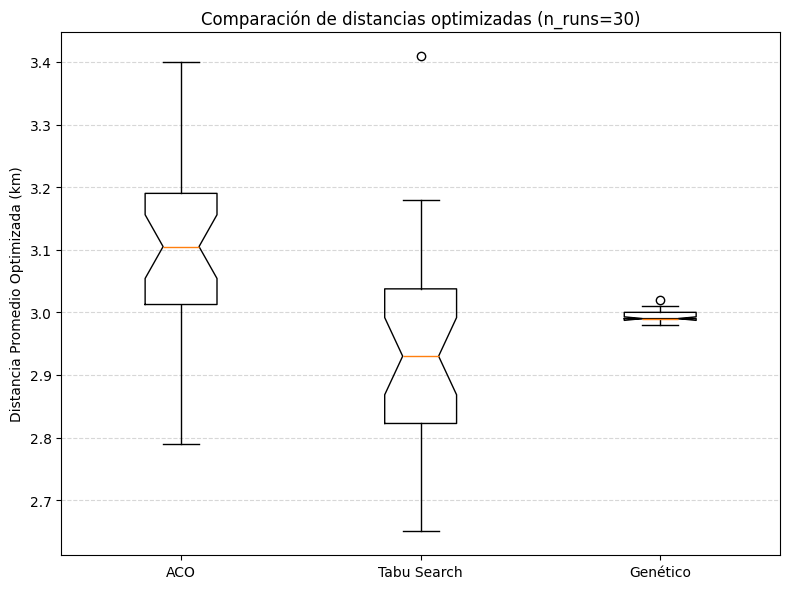


Resumen ACO: {'n': 30, 'mediana': np.float64(3.105), 'media': np.float64(3.0973), 'std': np.float64(0.1364), 'min': np.float64(2.79), 'max': np.float64(3.4)}
Resumen TS: {'n': 30, 'mediana': np.float64(2.93), 'media': np.float64(2.9433), 'std': np.float64(0.165), 'min': np.float64(2.65), 'max': np.float64(3.41)}
Resumen GA: {'n': 30, 'mediana': np.float64(2.99), 'media': np.float64(2.996), 'std': np.float64(0.0092), 'min': np.float64(2.98), 'max': np.float64(3.02)}


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time

n_runs = 30
seed = 42
np.random.seed(seed)

dist_aco = []
dist_ts = []
dist_ga = []

print("Iniciando experimentos (esto puede tardar según n_runs y la carga de los algoritmos)...")

modo = "balanceado"
config = parametros["ACO"][modo]
for i in range(n_runs):
    np.random.seed(seed + i)
    res = algoritmo_aco(
        matriz_hibrida, matriz_tiempos,
        num_hormigas=config["hormigas"],
        num_iteraciones=config["iters"],
        evaporacion=config["evap"],
        alfa=config["alfa"],
        beta=config["beta"]
    )
    dist_aco.append(res["Distancia Promedio Optimizada (km)"])

modo = "balanceado"
config_ts = parametros["TS"][modo]
for i in range(n_runs):
    np.random.seed(seed + 1000 + i)
    res = busqueda_tabu(
        matriz_hibrida, matriz_tiempos,
        tamaño_tabu=config_ts["tabu"],
        num_iteraciones=config_ts["iters"],
        num_vecinos=config_ts["vecinos"]
    )
    dist_ts.append(res["Distancia Promedio Optimizada (km)"])

modo = "balanceado"
config_ga = parametros["GA"][modo]
for i in range(n_runs):
    np.random.seed(seed + 2000 + i)
    res = algoritmo_genetico(
        matriz_hibrida, matriz_tiempos,
        generaciones=config_ga["gens"],
        tamaño_poblacion=config_ga["pob"],
        prob_mutacion=config_ga["mut"]
    )
    dist_ga.append(res["Distancia Promedio Optimizada (km)"])

print("Experimentos finalizados. Preparando boxplot...")

data = [dist_aco, dist_ts, dist_ga]
labels = ["ACO", "Tabu Search", "Genético"]

plt.figure(figsize=(8,6))
plt.boxplot(data, labels=labels, notch=True, showfliers=True)
plt.ylabel("Distancia Promedio Optimizada (km)")
plt.title(f"Comparación de distancias optimizadas (n_runs={n_runs})")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.savefig("boxplot_distancias_optimizada.png", dpi=300)
plt.show()

def resumen(lista):
    return {
        "n": len(lista),
        "mediana": round(np.median(lista), 4),
        "media": round(np.mean(lista), 4),
        "std": round(np.std(lista), 4),
        "min": round(np.min(lista), 4),
        "max": round(np.max(lista), 4)
    }

print("\nResumen ACO:", resumen(dist_aco))
print("Resumen TS:", resumen(dist_ts))
print("Resumen GA:", resumen(dist_ga))


# PRUEBAS DE NORMALIDAD

In [ ]:
from scipy.stats import shapiro, mannwhitneyu
import numpy as np
import random

def obtener_distancias_tramos(ruta, matriz):
    return [
        matriz[ruta[i]][ruta[i + 1]]
        for i in range(len(ruta) - 1)
    ]

ruta_aco = resultados_aco["Ruta Óptima"]
ruta_tabu = resultados_ts["Ruta Óptima"]
ruta_gen = resultados_ga["Ruta Óptima"]

matriz = matriz_distancias

dist_aco_completa = obtener_distancias_tramos(ruta_aco, matriz)
dist_tabu_completa = obtener_distancias_tramos(ruta_tabu, matriz)
dist_gen_completa = obtener_distancias_tramos(ruta_gen, matriz)

dist_reales_completa = df["Distancia (km)"].dropna().astype(float).values

tam = min(300, len(dist_aco_completa), len(dist_reales_completa))
indices = random.sample(range(tam), tam)

dist_aco = np.array([dist_aco_completa[i] for i in indices])
dist_tabu = np.array([dist_tabu_completa[i] for i in indices])
dist_gen = np.array([dist_gen_completa[i] for i in indices])
dist_reales = np.array([dist_reales_completa[i] for i in indices])

print("\n=== Primeras 10 distancias por tramo ===")
print("ACO:", np.round(dist_aco[:10], 2))
print("Tabú:", np.round(dist_tabu[:10], 2))
print("Genético:", np.round(dist_gen[:10], 2))
print("Reales:", np.round(dist_reales[:10], 2))

def prueba_shapiro(nombre, datos):
    stat, p = shapiro(datos)
    print(f"{nombre}: Estadístico={stat:.4f}, p={p:.6f}")

print("\n=== PRUEBA DE NORMALIDAD (Shapiro-Wilk) ===")
prueba_shapiro("ACO", dist_aco)
prueba_shapiro("Tabú", dist_tabu)
prueba_shapiro("Genético", dist_gen)
prueba_shapiro("Reales", dist_reales)

def prueba_mw(nombre, datos_modelo, reales):
    stat, p = mannwhitneyu(datos_modelo, reales, alternative='two-sided')
    print(f"{nombre} vs Reales -> U={stat:.4f}, p={p:.6f}")

print("\n=== PRUEBA MANN-WHITNEY U ===")
prueba_mw("ACO", dist_aco, dist_reales)
prueba_mw("Tabú", dist_tabu, dist_reales)
prueba_mw("Genético", dist_gen, dist_reales)



=== Primeras 10 distancias por tramo ===
ACO: [1.14 2.16 0.92 1.2  0.91 0.91 2.24 1.19 1.08 1.1 ]
Tabú: [0.88 2.62 1.8  0.95 1.07 1.08 1.16 0.92 1.16 0.92]
Genético: [1.05 1.89 1.08 1.38 1.29 1.3  1.8  1.33 0.92 1.22]
Reales: [0.8  3.58 3.62 3.86 0.8  2.67 0.8  5.57 6.21 3.64]

=== PRUEBA DE NORMALIDAD (Shapiro-Wilk) ===
ACO: Estadístico=0.7465, p=0.000000
Tabú: Estadístico=0.7340, p=0.000000
Genético: Estadístico=0.8321, p=0.000003
Reales: Estadístico=0.8585, p=0.000016

=== PRUEBA MANN-WHITNEY U ===
ACO vs Reales -> U=1024.0000, p=0.016224
Tabú vs Reales -> U=1074.0000, p=0.036838
Genético vs Reales -> U=1043.0000, p=0.022392
